In [20]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
import seaborn as  sns

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'dataset'
data_dir = pathlib.Path(DATASET_PATH)
commands = tf.io.gfile.listdir(str(data_dir))
print("Commands : ", commands)

Commands :  ['Down', 'Engine', 'Off', 'On', 'One', 'Three', 'Two', 'Up', 'Window', 'Wiper']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir)+ '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("Number of total examples : ", num_samples)
print("Number of examples per label : ", len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of total examples :  250
Number of examples per label :  25


In [7]:
train_files = filenames[0:200]
val_files = filenames[200:225]
test_files = filenames[225:]

print("Training set size : ", len(train_files))
print("Validation set size : ", len(val_files))
print("Test set size : ", len(test_files))

Training set size :  200
Validation set size :  25
Test set size :  25


In [10]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents = audio_binary)
    return tf.squeeze(audio, axis = -1)
def get_label(file_path):
    parts = tf.strings.split(input = file_path, sep = os.path.sep)
    return parts[-2]
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func = get_waveform_and_label, num_parallel_calls = AUTOTUNE)

In [21]:
def get_spectrogram(waveform):
    waveform = tf.cast(waveform, dtype = tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length = 255, frame_step = 188)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(map_func = get_spectrogram_and_label_id, num_parallel_calls = AUTOTUNE)
print(spectrogram_ds)

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>


In [19]:
commands

['Down', 'Engine', 'Off', 'On', 'One', 'Three', 'Two', 'Up', 'Window', 'Wiper']

tf.Tensor(1, shape=(), dtype=int64)
1
tf.Tensor(3, shape=(), dtype=int64)
3
tf.Tensor(2, shape=(), dtype=int64)
2
tf.Tensor(0, shape=(), dtype=int64)
0
tf.Tensor(8, shape=(), dtype=int64)
8
tf.Tensor(2, shape=(), dtype=int64)
2
tf.Tensor(1, shape=(), dtype=int64)
1
tf.Tensor(4, shape=(), dtype=int64)
4
tf.Tensor(2, shape=(), dtype=int64)
2


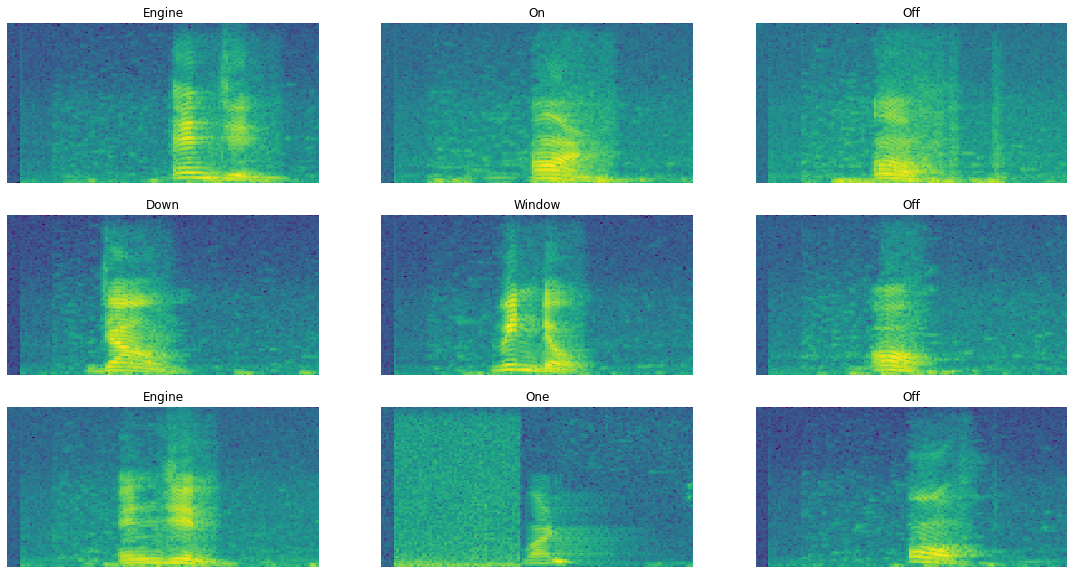

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(19, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  print(label_id)
  print(label_id.numpy())
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [26]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func = get_waveform_and_label, num_parallel_calls = AUTOTUNE)
    output_ds = output_ds.map(map_func = get_spectrogram_and_label_id, num_parallel_calls = AUTOTUNE)
    return output_ds

In [27]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [28]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [29]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [32]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print("Input Shape : ", input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(data = spectrogram_ds.map(map_func = lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape = input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.Conv2D(64, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input Shape :  (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)         

In [33]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
)

In [36]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    
)

Epoch 1/100
4/4 [==============================] - 0s 82ms/step - loss: 0.3234 - accuracy: 0.9050 - val_loss: 1.3942 - val_accuracy: 0.7600
Epoch 2/100
4/4 [==============================] - 0s 78ms/step - loss: 0.2633 - accuracy: 0.8800 - val_loss: 1.3247 - val_accuracy: 0.7600
Epoch 3/100
4/4 [==============================] - 0s 74ms/step - loss: 0.2475 - accuracy: 0.9050 - val_loss: 1.1901 - val_accuracy: 0.7600
Epoch 4/100
4/4 [==============================] - 0s 82ms/step - loss: 0.3227 - accuracy: 0.8950 - val_loss: 1.1821 - val_accuracy: 0.7200
Epoch 5/100
4/4 [==============================] - 0s 79ms/step - loss: 0.2375 - accuracy: 0.9300 - val_loss: 1.0764 - val_accuracy: 0.8000
Epoch 6/100
4/4 [==============================] - 0s 82ms/step - loss: 0.2819 - accuracy: 0.9050 - val_loss: 1.0746 - val_accuracy: 0.7600
Epoch 7/100
4/4 [==============================] - 0s 76ms/step - loss: 0.1504 - accuracy: 0.9750 - val_loss: 1.0493 - val_accuracy: 0.8000
Epoch 8/100
4/4 [===

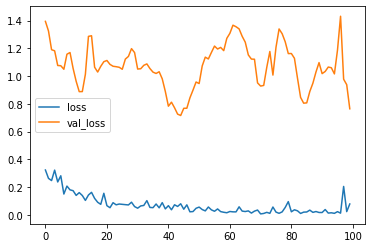

In [37]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [38]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [39]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 80%


In [40]:
model.save(os.path.join("trained_weights", "model1_12_27.h5"))

In [41]:
for audio, _ in test_ds:
    print(type(audio))
    print(audio.shape)
    print(audio.numpy().shape)
    print('\t')

<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 129, 1)
	
<class 'tensorflow.python.framework.ops.EagerTensor'>
(124, 129, 1)
(124, 12